**Group Project**

## Getting the Data

https://www.kaggle.com/datasets/davidcariboo/player-scores

## Merging the Data

In [66]:
import pandas as pd
import numpy as np
import sklearn

In [67]:
# Reading CSV files into dataframes
appearances = pd.read_csv('appearances.csv')
club_games = pd.read_csv('club_games.csv')
clubs = pd.read_csv('clubs.csv')
competitions = pd.read_csv('competitions.csv')
game_events = pd.read_csv('game_events.csv')
games = pd.read_csv('games.csv')
player_valuations = pd.read_csv('player_valuations.csv')
players = pd.read_csv('players.csv')

In [68]:
# Yearly Player Game Stats
appearances['date'] = pd.to_datetime(appearances['date'])
appearances['year'] = appearances['date'].dt.year
player_games_stats = appearances.\
    groupby(['player_id', 'year']).\
    agg(avg_game_dur = ('minutes_played', 'mean'),
        avg_games_played = ('appearance_id', 'count'),
        avg_yellow_cards = ('yellow_cards', 'mean'),
        avg_red_cards = ('red_cards', 'mean'),
        avg_goals = ('goals', 'mean'),
        avg_assists = ('assists', 'mean'),
        avg_minutes_played = ('minutes_played', 'mean')).\
    reset_index()
player_games_stats.head(1)

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played
0,10,2014.0,33.066667,15,0.133333,0.0,0.266667,0.2,33.066667


In [69]:
# Yearly Player Games Played (away & home)
player_games_home_away = appearances[['player_id', 'game_id', 'player_club_id', 'year']].\
    rename(columns={'player_club_id':'club_id'}).\
    merge(club_games, on=['club_id', 'game_id'], how='left').\
    groupby(['player_id', 'year', 'hosting']).\
    agg(games_played = ('game_id', 'count')).\
    reset_index().\
    pivot(index=['player_id','year'], columns='hosting', values='games_played').\
    reset_index().\
    rename(columns={'Away': 'games_played_away', 'Home': 'games_played_home'})
player_games_home_away.head(1)

hosting,player_id,year,games_played_away,games_played_home
0,10,2014.0,7.0,8.0


In [70]:
# Yearly Player Win Percentage (away & home)
player_win_perc_home_away = appearances[['player_id', 'game_id', 'player_club_id', 'year']].\
    rename(columns={'player_club_id':'club_id'}).\
    merge(club_games, on=['club_id', 'game_id'], how='left').\
    groupby(['player_id', 'year', 'hosting']).\
    agg(win_perc = ('is_win', 'mean')).\
    reset_index().\
    pivot(index=['player_id','year'], columns='hosting', values='win_perc').\
    reset_index().\
    rename(columns={'Away': 'away_win_percentage', 'Home': 'home_win_percentage'})
player_win_perc_home_away.head(1)

hosting,player_id,year,away_win_percentage,home_win_percentage
0,10,2014.0,0.285714,0.75


In [71]:
# Yearly Player Win Percentage (total)
player_win_perc = appearances[['player_id', 'game_id', 'player_club_id', 'year']].\
    rename(columns={'player_club_id':'club_id'}).\
    merge(club_games, on=['club_id', 'game_id'], how='left').\
    groupby(['player_id', 'year']).\
    agg(win_perc = ('is_win', 'mean')).\
    reset_index()
player_win_perc.head(1)

,player_id,year,win_perc
0,10,2014.0,0.533333


In [72]:
# Yearly Games Played by Competition Type
player_comp_types = appearances[['player_id', 'game_id', 'year']].\
    merge(games, on='game_id', how='left').\
    groupby(['player_id', 'year', 'competition_type']).\
    agg(competitions_attended = ('game_id', 'count')).\
    reset_index().\
    pivot(index=['player_id','year'], columns='competition_type', values='competitions_attended').\
    reset_index().\
    fillna({'domestic_cup':0, 'domestic_league':0, 'international_cup':0, 'other':0}).\
    rename(columns={'domestic_cup': 'games_player_domestic_cup', 'domestic_league': 'games_played_domestic_league',
            'international_cup': 'games_player_international_cup', 'other': 'games_played_other'})
player_comp_types.head(1)

competition_type,player_id,year,games_player_domestic_cup,games_played_domestic_league,games_player_international_cup,games_played_other
0,10,2014.0,1.0,14.0,0.0,0.0


In [73]:
# Player Popularity
player_pop = appearances[['player_id', 'game_id', 'year']].\
    merge(games, on='game_id', how='left').\
    groupby(['player_id', 'year']).\
    agg(player_avg_game_attendance = ('attendance', 'mean')).\
    reset_index()
player_pop.head(1)

,player_id,year,player_avg_game_attendance
0,10,2014.0,25929.266667


In [74]:
# Player Stats
players['date_of_birth'] = pd.to_datetime(players['date_of_birth'])
players['year_of_birth'] = players['date_of_birth'].dt.year
player_relevant_stats = players[['player_id', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'position', 'sub_position', 'foot', 'height_in_cm', 'year_of_birth']]
player_relevant_stats.head(1)

,player_id,country_of_citizenship,country_of_birth,city_of_birth,position,sub_position,foot,height_in_cm,year_of_birth
0,134354,Belgium,Belgium,Aalst,Attack,Centre-Forward,Right,0,1995.0


In [75]:
# Player Valuation (Mnay NA Values because it is tracked much earlier than stats)
player_valuations['date'] = pd.to_datetime(player_valuations['date'])
player_valuations['year'] = player_valuations['date'].dt.year
player_yearly_val =player_valuations.\
    groupby(['player_id', 'year']).\
    agg(mean_market_value_in_eur = ('market_value_in_eur', 'mean'),
        max_market_value_in_eur = ('market_value_in_eur', 'max')).\
    reset_index()

In [76]:
# Final Aggregation
data = player_games_stats.\
    merge(player_games_home_away, on=['player_id', 'year'], how='outer').\
    merge(player_win_perc_home_away, on=['player_id', 'year'], how='outer').\
    merge(player_win_perc, on=['player_id', 'year'], how='outer').\
    merge(player_comp_types, on=['player_id', 'year'], how='outer').\
    merge(player_pop, on=['player_id', 'year'], how='outer').\
    merge(player_yearly_val, on=['player_id', 'year'], how='outer').\
    merge(player_relevant_stats, on=['player_id'], how='left')
data['age'] = data['year'] - data['year_of_birth']
data.columns

Index(['player_id', 'year', 'avg_game_dur', 'avg_games_played',
       'avg_yellow_cards', 'avg_red_cards', 'avg_goals', 'avg_assists',
       'avg_minutes_played', 'games_played_away', 'games_played_home',
       'away_win_percentage', 'home_win_percentage', 'win_perc',
       'games_player_domestic_cup', 'games_played_domestic_league',
       'games_player_international_cup', 'games_played_other',
       'player_avg_game_attendance', 'mean_market_value_in_eur',
       'max_market_value_in_eur', 'country_of_citizenship', 'country_of_birth',
       'city_of_birth', 'position', 'sub_position', 'foot', 'height_in_cm',
       'year_of_birth', 'age'],
      dtype='object')

In [77]:
# For Imputation (Filling some null values with 0)
data = data.query('avg_games_played > 0')
data = data.dropna(subset=['win_perc', 'mean_market_value_in_eur'])
data = data.fillna({'games_played_away': 0, 
                    'games_played_home': 0, 
                    'games_player_domestic_cup': 0, 
                    'games_played_domestic_league': 0, 
                    'games_player_international_cup': 0, 
                    'games_played_other': 0,})

for col in data.columns:
    null_rows_idx = data[[col]].isnull().any(axis=1)
    if len(data[null_rows_idx]) > 0:
        print(col, data[null_rows_idx].shape)
# Output shows us which columns still have null values which we will fix/impute later in Data Cleaning

data.to_csv('data_merged.csv')

away_win_percentage (2982, 30)
home_win_percentage (3018, 30)
country_of_birth (1319, 30)
city_of_birth (1316, 30)
sub_position (5415, 30)
foot (1067, 30)
year_of_birth (19, 30)
age (19, 30)


## Analyzing the Data Structure

In [78]:
data.head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,max_market_value_in_eur,country_of_citizenship,country_of_birth,city_of_birth,position,sub_position,foot,height_in_cm,year_of_birth,age
0,10,2014.0,33.066667,15.0,0.133333,0.0,0.266667,0.200000,33.066667,7.0,...,1000000.0,Germany,Poland,Opole,Attack,Centre-Forward,Right,184.0,1978.0,36.0
1,10,2015.0,67.472222,36.0,0.166667,0.0,0.333333,0.222222,67.472222,17.0,...,1000000.0,Germany,Poland,Opole,Attack,Centre-Forward,Right,184.0,1978.0,37.0
2,10,2016.0,53.900000,20.0,0.050000,0.0,0.400000,0.250000,53.900000,7.0,...,1000000.0,Germany,Poland,Opole,Attack,Centre-Forward,Right,184.0,1978.0,38.0
3,26,2014.0,90.000000,17.0,0.000000,0.0,0.000000,0.000000,90.000000,10.0,...,5000000.0,Germany,Germany,Diez,Goalkeeper,NaN,Left,190.0,1980.0,34.0
4,26,2015.0,90.000000,24.0,0.000000,0.0,0.000000,0.000000,90.000000,11.0,...,3000000.0,Germany,Germany,Diez,Goalkeeper,NaN,Left,190.0,1980.0,35.0


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62658 entries, 0 to 64923
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   player_id                       62658 non-null  int64  
 1   year                            62658 non-null  float64
 2   avg_game_dur                    62658 non-null  float64
 3   avg_games_played                62658 non-null  float64
 4   avg_yellow_cards                62658 non-null  float64
 5   avg_red_cards                   62658 non-null  float64
 6   avg_goals                       62658 non-null  float64
 7   avg_assists                     62658 non-null  float64
 8   avg_minutes_played              62658 non-null  float64
 9   games_played_away               62658 non-null  float64
 10  games_played_home               62658 non-null  float64
 11  away_win_percentage             59676 non-null  float64
 12  home_win_percentage             

In [80]:
data.describe()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,games_player_domestic_cup,games_played_domestic_league,games_player_international_cup,games_played_other,player_avg_game_attendance,mean_market_value_in_eur,max_market_value_in_eur,height_in_cm,year_of_birth,age
count,62658.000000,62658.000000,62658.000000,62658.000000,62658.000000,62658.000000,62658.000000,62658.000000,62658.000000,62658.000000,...,62658.000000,62658.000000,62658.000000,62658.000000,62658.000000,6.265800e+04,6.265800e+04,62658.000000,62639.000000,62639.000000
mean,197992.682084,2017.982684,64.143621,16.325002,0.141700,0.003829,0.075023,0.057653,64.143621,8.214673,...,1.056944,14.023572,1.196942,0.047544,14544.955876,3.879466e+06,4.399913e+06,180.367343,1991.949105,26.034212
std,160377.604951,2.469891,23.699159,11.584211,0.152391,0.024911,0.129976,0.094524,23.699159,5.894010,...,1.388077,9.935560,2.576588,0.259132,12958.930360,9.001116e+06,9.956643e+06,19.444474,5.023461,4.473795
min,10.000000,2014.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+04,1.000000e+04,0.000000,1972.000000,15.000000
25%,63459.000000,2016.000000,49.084239,7.000000,0.000000,0.000000,0.000000,0.000000,49.084239,3.000000,...,0.000000,6.000000,0.000000,0.000000,4462.049342,4.000000e+05,4.500000e+05,177.000000,1988.000000,23.000000
50%,160968.000000,2018.000000,70.250000,14.000000,0.111111,0.000000,0.000000,0.000000,70.250000,7.000000,...,1.000000,13.000000,0.000000,0.000000,10870.142857,1.000000e+06,1.000000e+06,182.000000,1992.000000,26.000000
75%,289510.000000,2020.000000,84.156076,24.000000,0.214286,0.000000,0.105263,0.090909,84.156076,12.000000,...,2.000000,21.000000,1.000000,0.000000,20835.597222,3.166667e+06,3.700000e+06,187.000000,1996.000000,29.000000
max,987700.000000,2022.000000,120.000000,59.000000,2.000000,1.000000,3.000000,2.000000,120.000000,31.000000,...,11.000000,44.000000,19.000000,5.000000,81365.000000,2.000000e+08,2.000000e+08,206.000000,2006.000000,44.000000


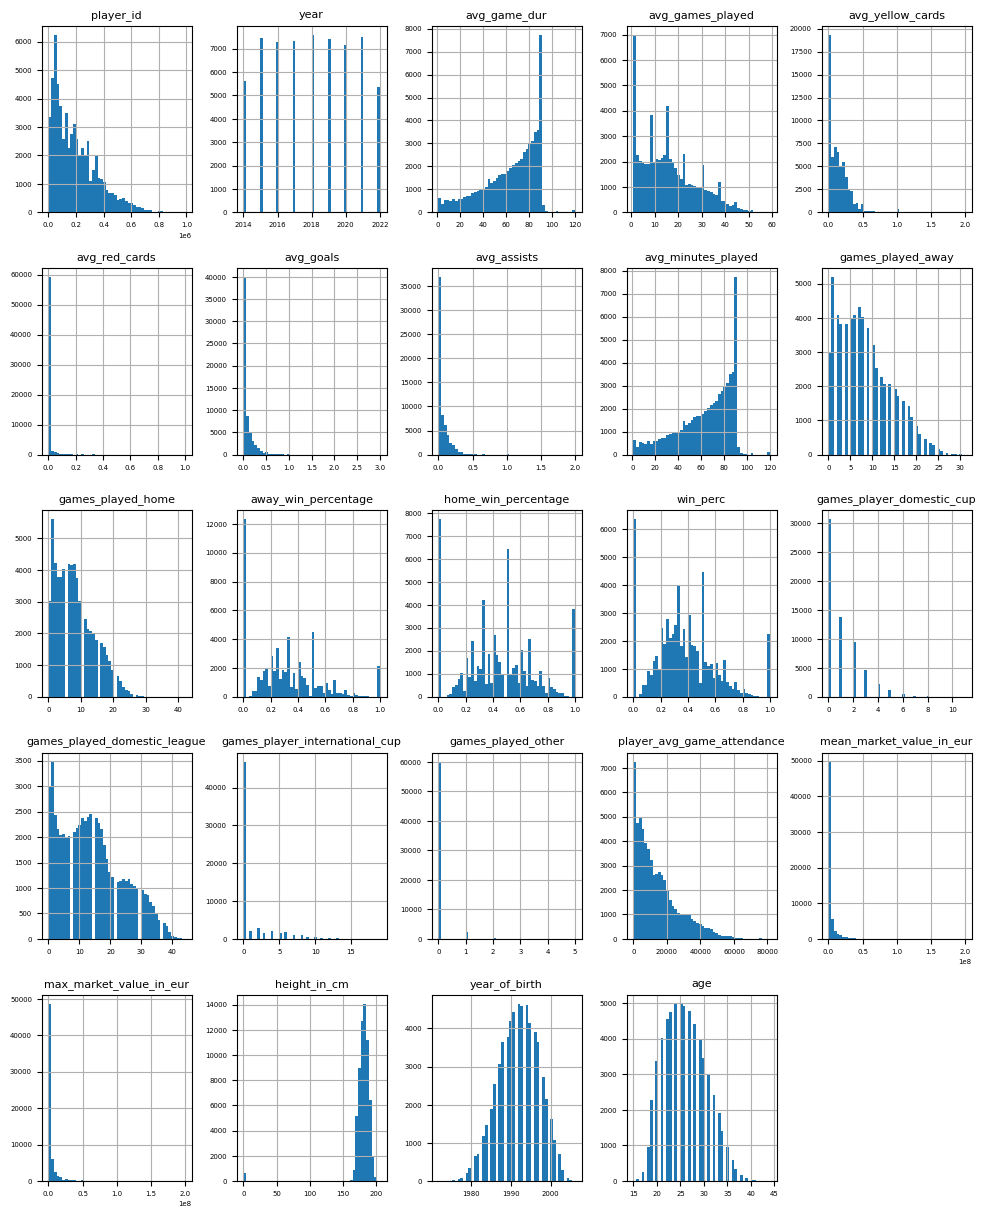

In [81]:
import matplotlib.pyplot as plt

plt.rc('font', size = 5)
plt.rc('axes', labelsize = 5, titlesize = 8)
plt.rc('legend', fontsize = 5)
plt.rc('xtick', labelsize = 5)
plt.rc('ytick', labelsize = 5)

data.hist(bins = 50, figsize = (12, 15))
plt.show()

Many variables are skewed to the left/right, meaning that they extend on the left/right of the median. This can make it difficult for our model to identify patterns. Later, we will transform these attributes to have normal distributions.

# Discover and Visualize the Data to Gain Insights

## Looking for Correlations

In [82]:
corr_matrix = data.corr()

In [83]:
corr_matrix["mean_market_value_in_eur"].sort_values(ascending=False)


relevant_cols = corr_matrix.columns.tolist()
cols_to_remove = ['player_id', 'year_of_birth', 'max_market_value_in_eur']
for col in cols_to_remove: relevant_cols.remove(col)

corr_vals = corr_matrix['mean_market_value_in_eur'][relevant_cols]
corr_vals[(corr_vals > 0.1) | (corr_vals < -0.1)]

year                              0.102692
avg_game_dur                      0.127588
avg_games_played                  0.408629
avg_goals                         0.247078
avg_assists                       0.217391
avg_minutes_played                0.127588
games_played_away                 0.398663
games_played_home                 0.404397
away_win_percentage               0.208742
home_win_percentage               0.194933
win_perc                          0.220895
games_player_domestic_cup         0.177162
games_played_domestic_league      0.331956
games_player_international_cup    0.428256
games_played_other                0.332320
player_avg_game_attendance        0.389819
mean_market_value_in_eur          1.000000
Name: mean_market_value_in_eur, dtype: float64

# Preparing the Data for Machine Learning Algorithms

## Data Cleaning

In [84]:
null_rows_idx = data.isnull().any(axis=1)
data.loc[null_rows_idx].head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,max_market_value_in_eur,country_of_citizenship,country_of_birth,city_of_birth,position,sub_position,foot,height_in_cm,year_of_birth,age
3,26,2014.0,90.000000,17.0,0.000000,0.0,0.000000,0.000000,90.000000,10.0,...,5000000.0,Germany,Germany,Diez,Goalkeeper,NaN,Left,190.0,1980.0,34.0
4,26,2015.0,90.000000,24.0,0.000000,0.0,0.000000,0.000000,90.000000,11.0,...,3000000.0,Germany,Germany,Diez,Goalkeeper,NaN,Left,190.0,1980.0,35.0
5,26,2016.0,92.000000,15.0,0.066667,0.0,0.000000,0.000000,92.000000,9.0,...,1000000.0,Germany,Germany,Diez,Goalkeeper,NaN,Left,190.0,1980.0,36.0
6,26,2017.0,60.333333,3.0,0.000000,0.0,0.000000,0.000000,60.333333,1.0,...,1000000.0,Germany,Germany,Diez,Goalkeeper,NaN,Left,190.0,1980.0,37.0
8,65,2014.0,76.705882,17.0,0.235294,0.0,0.294118,0.117647,76.705882,8.0,...,3500000.0,Bulgaria,Bulgaria,Blagoevgrad,Attack,Centre-Forward,NaN,0.0,1981.0,33.0


In [85]:
null_counts = data.isnull().sum(axis=1)
num_null_rows = (null_counts > 0).sum()

print(f'There are {num_null_rows} rows with null values in the dataset.')

There are 12087 rows with null values in the dataset.


In [86]:
# There are only 19 missing values here and taking the median of age would not make sense so we are dropping it altogether

data.dropna(subset=['age'], inplace=True)

In [116]:
# Filling in missing sub_position values

# Grouping sub_position by position
sub_positions_by_position = data.groupby('position')['sub_position'].apply(list)

# Finding the most frequent sub_position for each position
sub_positions_count_by_position = sub_positions_by_position.apply(lambda x: pd.Series(x).value_counts()).fillna(0).astype(int)
sub_positions_count_by_position_dict = sub_positions_count_by_position.to_dict()

# Finding the most frequent sub_position for each position
most_frequent_sub_positions_by_position = sub_positions_count_by_position.idxmax(axis=1)

# Creating a new DataFrame with position and most frequent sub_position columns
df = pd.DataFrame({'position': most_frequent_sub_positions_by_position.index,
                   'most_frequent_sub_position': most_frequent_sub_positions_by_position.values})

df

,position,most_frequent_sub_position
0,Attack,Centre-Forward
1,Defender,Centre-Back
2,Goalkeeper,Centre-Forward
3,Midfield,Central Midfield


In [114]:
df_merged = df.merge(sub_positions_count_by_position, left_on='position', right_index=True)
most_frequent_sub_positions_dict = df_merged.set_index('position')['most_frequent_sub_position'].to_dict()

# Replace sub_position null values with most frequent sub_positions for their corresponding positions
data['sub_position'] = data.apply(lambda row: most_frequent_sub_positions_dict[row['position']] if pd.isnull(row['sub_position']) else row['sub_position'], axis=1)

In [117]:
# Just to be sure that all worked, count the number of null values in the sub_position column
num_null_values = data['sub_position'].isnull().sum()

print(f"There are {num_null_values} null values in the sub_position column")

There are 0 null values in the sub_position column


In [118]:
# Imputing the rest

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [119]:
data_num = data.select_dtypes(include=[np.number])

In [120]:
imputer.fit(data_num)

SimpleImputer(strategy='median')

In [121]:
imputer.statistics_

array([1.60986000e+05, 2.01800000e+03, 7.02500000e+01, 1.40000000e+01,
       1.11111111e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.02500000e+01, 7.00000000e+00, 7.00000000e+00, 2.85714286e-01,
       4.28571429e-01, 3.47826087e-01, 1.00000000e+00, 1.30000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.08662500e+04, 1.00000000e+06,
       1.00000000e+06, 1.82000000e+02, 1.99200000e+03, 2.60000000e+01])

In [122]:
X = imputer.transform(data_num)

In [123]:
data_tr = pd.DataFrame(X, columns = data_num.columns,
                          index = data_num.index)

In [124]:
data_tr.loc[null_rows_idx].head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,games_player_domestic_cup,games_played_domestic_league,games_player_international_cup,games_played_other,player_avg_game_attendance,mean_market_value_in_eur,max_market_value_in_eur,height_in_cm,year_of_birth,age
3,26.0,2014.0,90.000000,17.0,0.000000,0.0,0.000000,0.000000,90.000000,10.0,...,0.0,12.0,5.0,0.0,57578.411765,5.000000e+06,5000000.0,190.0,1980.0,34.0
4,26.0,2015.0,90.000000,24.0,0.000000,0.0,0.000000,0.000000,90.000000,11.0,...,0.0,13.0,11.0,0.0,55057.333333,2.000000e+06,3000000.0,190.0,1980.0,35.0
5,26.0,2016.0,92.000000,15.0,0.066667,0.0,0.000000,0.000000,92.000000,9.0,...,2.0,7.0,6.0,0.0,50741.666667,1.000000e+06,1000000.0,190.0,1980.0,36.0
6,26.0,2017.0,60.333333,3.0,0.000000,0.0,0.000000,0.000000,60.333333,1.0,...,0.0,2.0,1.0,0.0,62709.333333,9.166667e+05,1000000.0,190.0,1980.0,37.0
8,65.0,2014.0,76.705882,17.0,0.235294,0.0,0.294118,0.117647,76.705882,8.0,...,0.0,12.0,5.0,0.0,14838.882353,3.250000e+06,3500000.0,0.0,1981.0,33.0


In [125]:
# Just to make sure eveyrthing worked
null_counts = data_tr.isnull().sum(axis=1)
num_null_rows = (null_counts > 0).sum()

print(f'There are {num_null_rows} rows with null values in the dataset.')

There are 0 rows with null values in the dataset.


## Handling Text and Categorical Attributes

Now let's preprocess the categorical input features, `country_of_citizenship`, `country_of_birth`, `city_of_birth`, `position`, `sub_position`, `foot`:

In [126]:
data_cat = data[["country_of_citizenship", "country_of_birth", "city_of_birth", "position", "sub_position", "foot"]]
data_cat.head(8)

,country_of_citizenship,country_of_birth,city_of_birth,position,sub_position,foot
0,Germany,Poland,Opole,Attack,Centre-Forward,Right
1,Germany,Poland,Opole,Attack,Centre-Forward,Right
2,Germany,Poland,Opole,Attack,Centre-Forward,Right
3,Germany,Germany,Diez,Goalkeeper,Centre-Forward,Left
4,Germany,Germany,Diez,Goalkeeper,Centre-Forward,Left
5,Germany,Germany,Diez,Goalkeeper,Centre-Forward,Left
6,Germany,Germany,Diez,Goalkeeper,Centre-Forward,Left
8,Bulgaria,Bulgaria,Blagoevgrad,Attack,Centre-Forward,NaN


In [127]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
data_cat_encoded = cat_encoder.fit_transform(data_cat).toarray()

encoded_cols = cat_encoder.get_feature_names(data_cat.columns)
data_encoded = pd.DataFrame(data_cat_encoded, columns=encoded_cols)

C:\Users\rohan\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [128]:
data_encoded

,country_of_citizenship_Afghanistan,country_of_citizenship_Albania,country_of_citizenship_Algeria,country_of_citizenship_Angola,country_of_citizenship_Antigua and Barbuda,country_of_citizenship_Argentina,country_of_citizenship_Armenia,country_of_citizenship_Aruba,country_of_citizenship_Australia,country_of_citizenship_Austria,...,sub_position_Left Winger,sub_position_Left-Back,sub_position_Right Midfield,sub_position_Right Winger,sub_position_Right-Back,sub_position_Second Striker,foot_Both,foot_Left,foot_Right,foot_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
62635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
62636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
62637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
